# 数据预处理


缺失值填充 & 异常值处理

## 1. 数据导入

### 1.1 导入所需工具包

In [9]:
#导入工具包
import numpy as np

### 1.2 读取数据

In [10]:
# 读取数据
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target 

D:\software\Ananconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


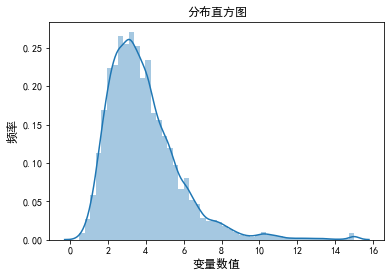

In [11]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']

fig, ax = plt.subplots()
sns.distplot(X[:,0], hist = True, kde=True) # 以第一个变量为例
ax.set_title('分布直方图', fontsize=12)
ax.set_xlabel('变量数值', fontsize=12)
ax.set_ylabel('频率', fontsize=12); # 这个变量为长尾分布

## 2. 缺失值处理

### 2.1 Imputation of missing values 缺失值填补

在实际操作中，数据集中可能存在缺失值。然而，这种稀疏的数据集与大多数 scikit-learn的模型不兼容，scikit-learn的模型假设所有特征都是数值的，且没有丢失值。所以在应用 scikit-learn 的模型之前，我们需要估算缺失的值  

但是一些新的模型，比如在其他包中实现的 XGboost、LightGBM 和 Catboost，均为数据集中丢失的值提供了支持。所以在应用这些模型时，我们不再需要填充数据集中丢失的值

#### Univariate feature imputation 单变量特征插补

假设第 i 列中有缺失值，那么我们将用常数或第 i 列的统计数据（平均值、中值或众数）对其进行估算

In [13]:
from sklearn.impute import SimpleImputer

test_set = X[0:10,0].copy() # 选择前十个变量作为测试集，无缺失值
test_set

array([8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6591, 3.12  ,
       2.0804, 3.6912])

In [14]:
# 手动生成缺失值
test_set[3] = np.nan
test_set[6] = np.nan

In [15]:
test_set

array([8.3252, 8.3014, 7.2574,    nan, 3.8462, 4.0368,    nan, 3.12  ,
       2.0804, 3.6912])

In [16]:
# 生成训练集，选择其余的样本作为训练集并手动生成缺失值
train_set = X[10:,0].copy()
train_set[3] = np.nan
train_set[6] = np.nan

In [17]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean') # 使用样本均值来填补缺失值
# 其余的填补方法： 'mean', 'median', 'most_frequent', 'constant'
imputer.fit(train_set.reshape(-1,1)) # 在训练集上训练
# 转换填补训练集与测试集
imputed_train = imputer.transform(train_set.reshape(-1,1)).reshape(-1) # 转换训练集
imputed_test = imputer.transform(test_set.reshape(-1,1)).reshape(-1) # 转换测试集


In [18]:
imputed_test

array([8.3252    , 8.3014    , 7.2574    , 3.87023658, 3.8462    ,
       4.0368    , 3.87023658, 3.12      , 2.0804    , 3.6912    ])

#### Multivariate feature imputation 多元特征插补

多元特征插补利用整个数据集的信息来估计和插补缺失值。在 scikit-learn 中，它以循环迭代的方式实现。

在每一步中，一个包含缺失值的特征列被指定为输出 y，其他特征列被视为输入 X。一个回归器在X上被训练然后用以预测y中的缺失值。这是以迭代的方式对每个特征进行，直到达到最大迭代次数限制。

## 2. 数据标准化

在线性回归，逻辑回归等线性模型中，不同尺度的特征之间难以比较。在基于欧氏距离的 k-means 聚类或 KNN 模型中，特征的不同尺度也会影响到距离测算。缩放可以有效的解决以上的问题，让变量之间可比性增强。而对于基于梯度下降的算法，数据缩放也会有效的特征运行速度。

将数值特征分箱离散化

**一些常用模型的分类**
  
|模型名称 | 是否需要缩放 |
|--|--|
| 向量支持机, K最近邻算法, 主成分分析, K均值聚类, 线性回归, 逻辑回归, 线性判别分析| $\checkmark$ |
| 朴素贝叶斯, 基于树的机器学习算法 | $\times$ |

* 注：偏度影响也会PCA 模型，因此有些人推荐使用幂变换来消除偏度。

#### 1. Stardard Scaling 标准缩放（Z 分数标准化）

In [5]:
from sklearn.preprocessing import StandardScaler

# 为了模拟数据科学家的实际操作，我们将
# 在训练集上训练 StandardScaler然后转换测试集
# 将第一列中的前十个样本作为测试集
# 将第一列中的其余样本作为训练集

test_set = X[0:10,0]
# 返回 array([8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6591, 3.12, 2.0804, 3.6912])
train_set = X[10:,0]

model = StandardScaler()

model.fit(train_set.reshape(-1,1)) # 在训练集上训练
# 转换训练集与测试集
transformed_train = model.transform(train_set.reshape(-1,1)).reshape(-1) # 转换训练集
transformed_test = model.transform(test_set.reshape(-1,1)).reshape(-1) # 转换测试集

# 以测试集结果为例：
# 返回测试集的缩放结果 transformed_test = array([ 2.34539745,  2.33286782,  1.78324852,  0.93339178, -0.0125957 ,
# 0.08774668, -0.11109548, -0.39490751, -0.94221041, -0.09419626])
# 返回结果与以下代码的返回结果一致 ((X[0:10,0] - X[10:,0].mean())/X[10:,0].std())

D:\software\Ananconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\software\Ananconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\software\Ananconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\software\Ananconda\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from curre

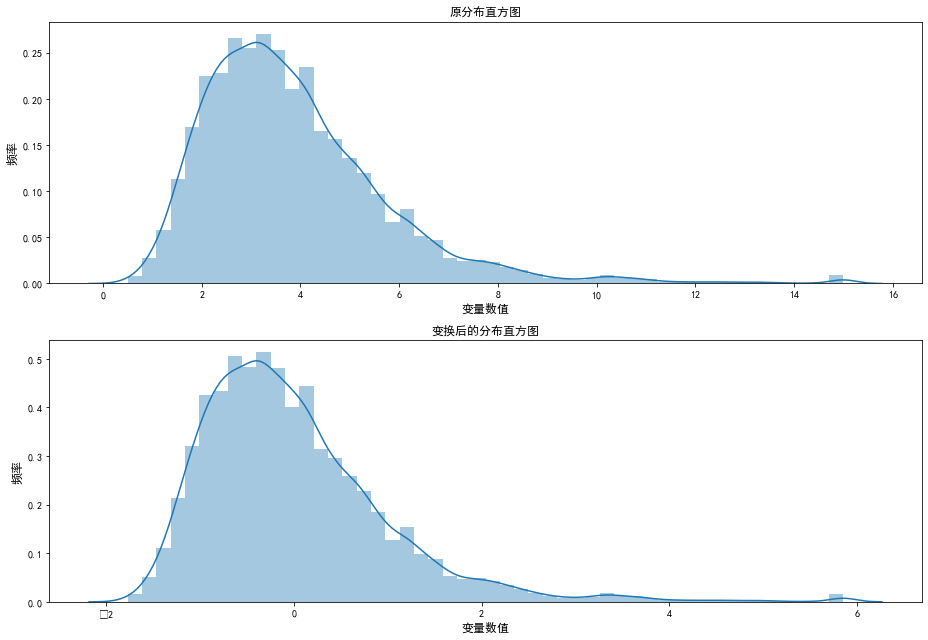

In [6]:
# 可视化缩放前后的分布对比
# 在整个变量上操作（不分训练集与测试集）

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize = (13,9))
sns.distplot(X[:,0], hist = True, kde=True, ax=ax[0])
ax[0].set_title('原分布直方图', fontsize=12)
ax[0].set_xlabel('变量数值', fontsize=12)
ax[0].set_ylabel('频率', fontsize=12); # 这个变量为长尾分布

model = StandardScaler()
model.fit(X[:,0].reshape(-1,1)) 
result = model.transform(X[:,0].reshape(-1,1)).reshape(-1)

# 可视化整个变量上缩放的结果
sns.distplot(result, hist = True, kde=True, ax=ax[1])
ax[1].set_title('变换后的分布直方图', fontsize=12)
ax[1].set_xlabel('变量数值', fontsize=12)
ax[1].set_ylabel('频率', fontsize=12); # 分布一致，但是变量的尺度已发生变化
fig.tight_layout()

#### MinMaxScaler 最大最小缩放 (按数值范围缩放)

假设我们想要将特征数值缩放到 (a, b)区间  
公式：${X}' = \frac{X - Min }{Max - Min} * (b - a) + a$   
$Min$ 是X中的最小值， $Max$ 是X中的最大值  
这种缩放方法同样对异常值较敏感，异常值会同时影响$Min$ 和 $Max$

In [7]:
from sklearn.preprocessing import MinMaxScaler

# 为了模拟数据科学家的实际操作，我们将
# 在训练集上训练 MinMaxScaler然后转换测试集
# 将第一列中的前十个样本作为测试集
# 将第一列中的其余样本作为训练集

test_set = X[0:10,0]
# 返回 array([8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6591, 3.12, 2.0804, 3.6912])
train_set = X[10:,0]

model = MinMaxScaler(feature_range=(0,1)) # 将缩放区间定为 (0,1)

model.fit(train_set.reshape(-1,1)) # 在训练集上训练
# 转换缩放训练集与测试集
transformed_train = model.transform(train_set.reshape(-1,1)).reshape(-1) # 转换训练集
transformed_test = model.transform(test_set.reshape(-1,1)).reshape(-1) # 转换测试集

# 以测试集结果为例：
# transformed_test = array([0.53966842, 0.53802706, 0.46602805, 0.35469856, 0.23077613,
# 0.24392077, 0.21787286, 0.18069406, 0.1089985 , 0.22008662])
# 返回结果与以下代码的返回结果一致： (X[0:10,0] - X[10:,0].min())/(X[10:,0].max()-X[10:,0].min())

D:\software\Ananconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\software\Ananconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


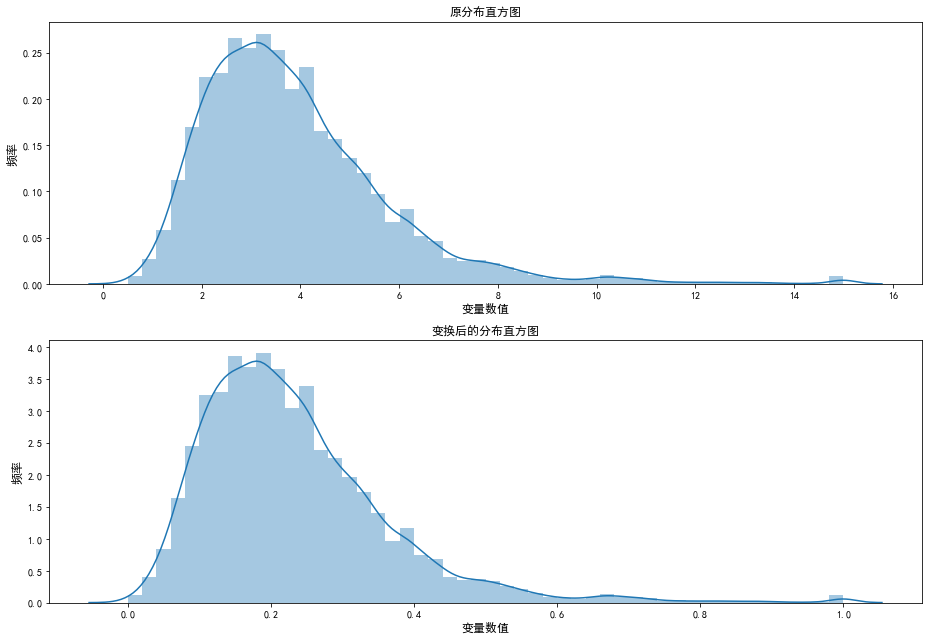

In [8]:
# 可视化缩放前后的分布对比
# 在整个变量上操作（不分训练集与测试集）

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize = (13,9))
sns.distplot(X[:,0], hist = True, kde=True, ax=ax[0])
ax[0].set_title('原分布直方图', fontsize=12)
ax[0].set_xlabel('变量数值', fontsize=12)
ax[0].set_ylabel('频率', fontsize=12); # 这个变量为长尾分布

model = MinMaxScaler(feature_range=(0,1))
model.fit(X[:,0].reshape(-1,1)) 
result = model.transform(X[:,0].reshape(-1,1)).reshape(-1)

# 可视化整个变量上缩放的结果
sns.distplot(result, hist = True, kde=True, ax=ax[1])
ax[1].set_title('变换后的分布直方图', fontsize=12)
ax[1].set_xlabel('变量数值', fontsize=12)
ax[1].set_ylabel('频率', fontsize=12); # 分布一致，但是变量的尺度已发生变化
fig.tight_layout() # 现变量分布于（0，1）区间